# New Section

In [10]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:02<00:00, 33.5MB/s]


In [11]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=e4e12d8b-b24d-4b87-aee5-a1982eef6273
To: /content/coco_captions.npy
100% 415M/415M [00:10<00:00, 38.1MB/s]


In [8]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000323327.jpg  
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.j

In [14]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [15]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np


In [16]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [17]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [18]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [19]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)


Caption embeddings (40504, 5, 512)


In [20]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [30]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import faiss
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# Ensure NLTK resources are downloaded (needed for tokenization)
nltk.download('punkt')

def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform

# Load COCO dataset
coco_dset = dset.CocoCaptions(root='/content/val2014',
                              annFile='/content/annotations/captions_val2014.json',
                              transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3]  # Load 4th sample
print("Image Size: ", img.shape)
print(target)

# Load embeddings and captions
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings', caption_embeddings.shape)

img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings', image_embeddings.shape)

# Flatten all captions into a single list
captions_flat = [caption for img_captions in target for caption in img_captions]

# Reshape caption_embeddings to 2D if it's originally 3D
if len(caption_embeddings.shape) == 3:
    caption_embeddings = caption_embeddings.reshape(-1, caption_embeddings.shape[-1])

def find_k_nearest_images(image_embedding, k):
    index = faiss.IndexFlatL2(image_embeddings.shape[1])
    index.add(image_embeddings)
    _, I = index.search(image_embedding.reshape(1, -1), k)
    return I.flatten()

def compute_query_vector(nearest_image_indices, k):
    nearest_captions_indices = nearest_image_indices * 5  # Assuming the first caption for each image
    nearest_captions_indices = [idx for idx in nearest_captions_indices if idx < len(caption_embeddings)]
    query_vector = np.mean(caption_embeddings[nearest_captions_indices], axis=0)
    return query_vector

def find_closest_caption(query_vector):
    index = faiss.IndexFlatL2(caption_embeddings.shape[1])
    index.add(caption_embeddings)
    _, I = index.search(query_vector.reshape(1, -1), 1)
    adjusted_index = min(I[0][0], len(captions_flat) - 1)
    return captions_flat[adjusted_index]

def caption_image_knn(image_index, k):
    image_embedding = image_embeddings[image_index]
    nearest_indices = find_k_nearest_images(image_embedding, k)
    query_vector = compute_query_vector(nearest_indices, k)
    caption = find_closest_caption(query_vector)
    return caption

# Tokenize and preprocess captions
def tokenize_and_preprocess(text):
    return nltk.word_tokenize(text.lower())

# Initialize the smoothing function
smoothing_func = SmoothingFunction().method1

# Compute BLEU score for a range of images using the smoothing function
predicted_captions = [caption_image_knn(i, 5) for i in range(100)]
ground_truth_captions = [captions_flat[i * 5: i * 5 + 5] for i in range(100)]

predicted_captions_tokenized = [tokenize_and_preprocess(pc) for pc in predicted_captions if pc]
ground_truth_captions_tokenized = [[tokenize_and_preprocess(gt) for gt in group if gt] for group in ground_truth_captions if group]

# Calculate cumulative BLEU scores with smoothing function for valid pairs
valid_pairs = [(gt, pc) for gt, pc in zip(ground_truth_captions_tokenized, predicted_captions_tokenized) if gt and pc]
cumulative_bleu_scores = [
    sentence_bleu(gt, pc, smoothing_function=smoothing_func, weights=(0.25, 0.25, 0.25, 0.25))
    for gt, pc in valid_pairs
]

average_cumulative_bleu_score = np.mean(cumulative_bleu_scores) if cumulative_bleu_scores else 0
print(f"Average Cumulative BLEU score with smoothing: {average_cumulative_bleu_score}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Caption embeddings (40504, 5, 512)
Image embeddings (40504, 512)
Average Cumulative BLEU score with smoothing: 0.1778279410038923


In [38]:
k_values = [1, 3, 5, 10, 20]  # Example values of k to try

for k in k_values:
    predicted_captions_k = [caption_image_knn(i, k) for i in range(100)]  # Use a subset for quicker computation
    predicted_captions_tokenized_k = [tokenize_and_preprocess(pc) for pc in predicted_captions_k if pc]

    valid_pairs_k = [(gt, pc) for gt, pc in zip(ground_truth_captions_tokenized, predicted_captions_tokenized_k) if gt and pc]
    cumulative_bleu_scores_k = [sentence_bleu(gt, pc, smoothing_function=smoothing_func) for gt, pc in valid_pairs_k]
    average_cumulative_bleu_score_k = np.mean(cumulative_bleu_scores_k) if cumulative_bleu_scores_k else 0

    print(f"Average Cumulative BLEU score with k={k}: {average_cumulative_bleu_score_k}")


Average Cumulative BLEU score with k=1: 0.007129163327244101
Average Cumulative BLEU score with k=3: 0.00904980907815205
Average Cumulative BLEU score with k=5: 0.007908134296903941
Average Cumulative BLEU score with k=10: 0.007245544973078822
Average Cumulative BLEU score with k=20: 0.007679251901047232


In [51]:
ng annotations into memory...
Done (t=0.71s)
creating index...
index created!
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-51-e768ddb746e1> in <cell line: 62>()
     69
     70     start_time = time.time()
---> 71     predicted_captions = [caption_image_with_index(i, k, index) for i in range(100)]
     72     elapsed_time = time.time() - start_time
     73

3 frames
/usr/local/lib/python3.10/dist-packages/faiss/class_wrappers.py in replacement_add(self, x)
    225         """
    226
--> 227         n, d = x.shape
    228         assert d == self.d
    229         x = np.ascontiguousarray(x, dtype='float32')

ValueError: too many values to unpack (expected 2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


ValueError: too many values to unpack (expected 2)

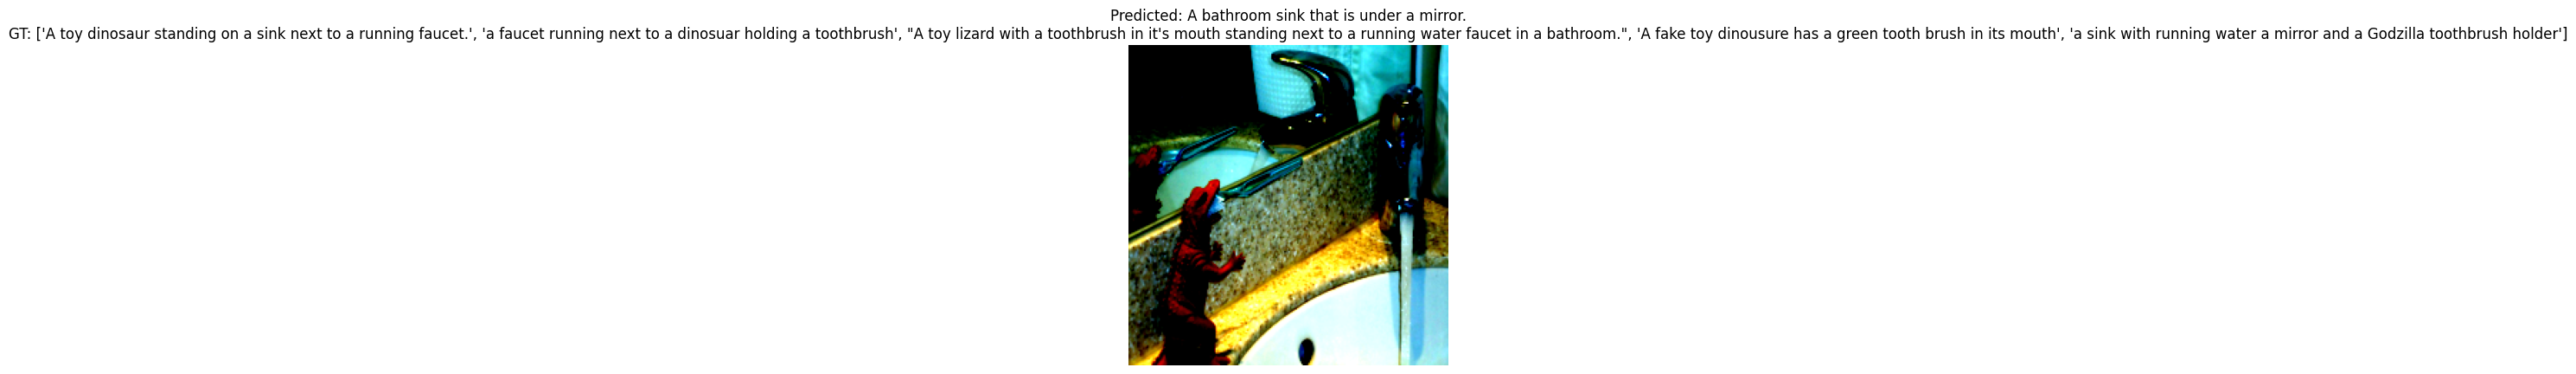

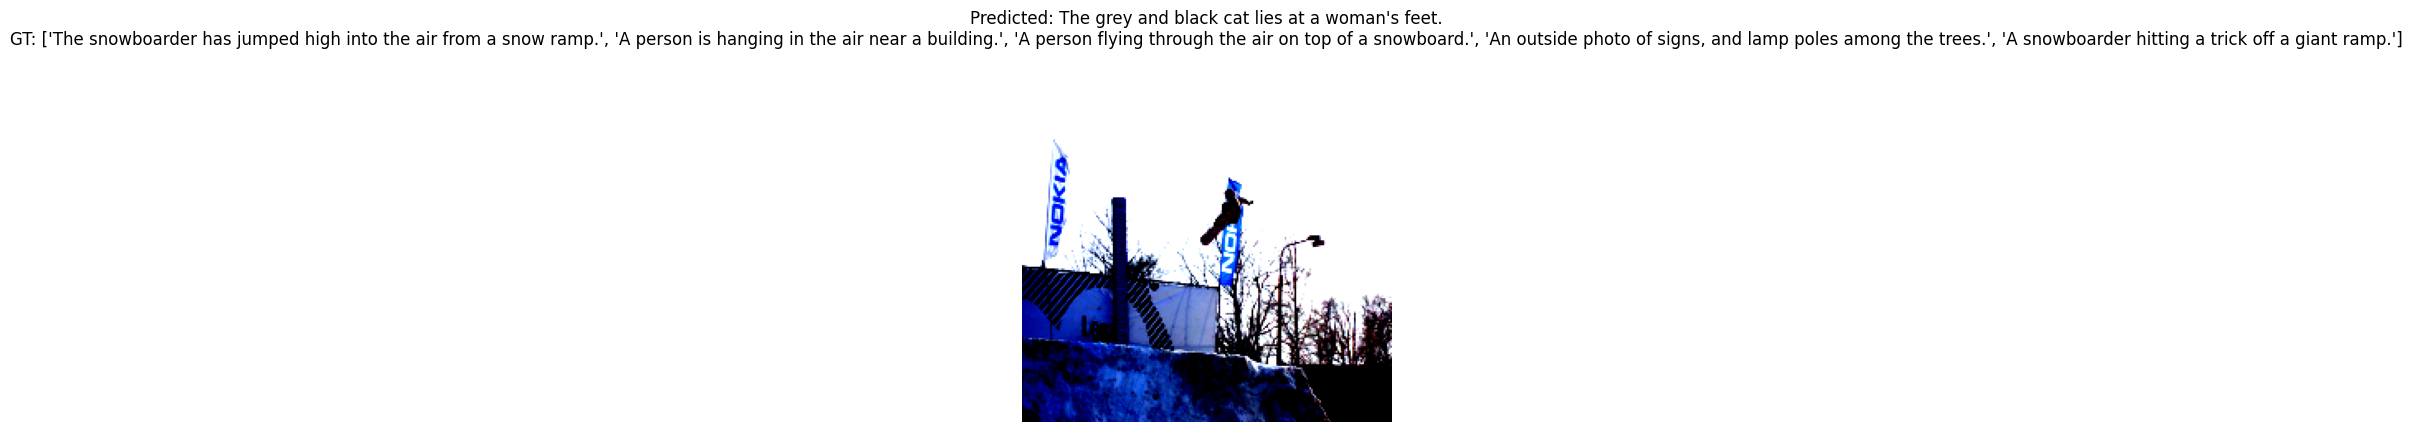

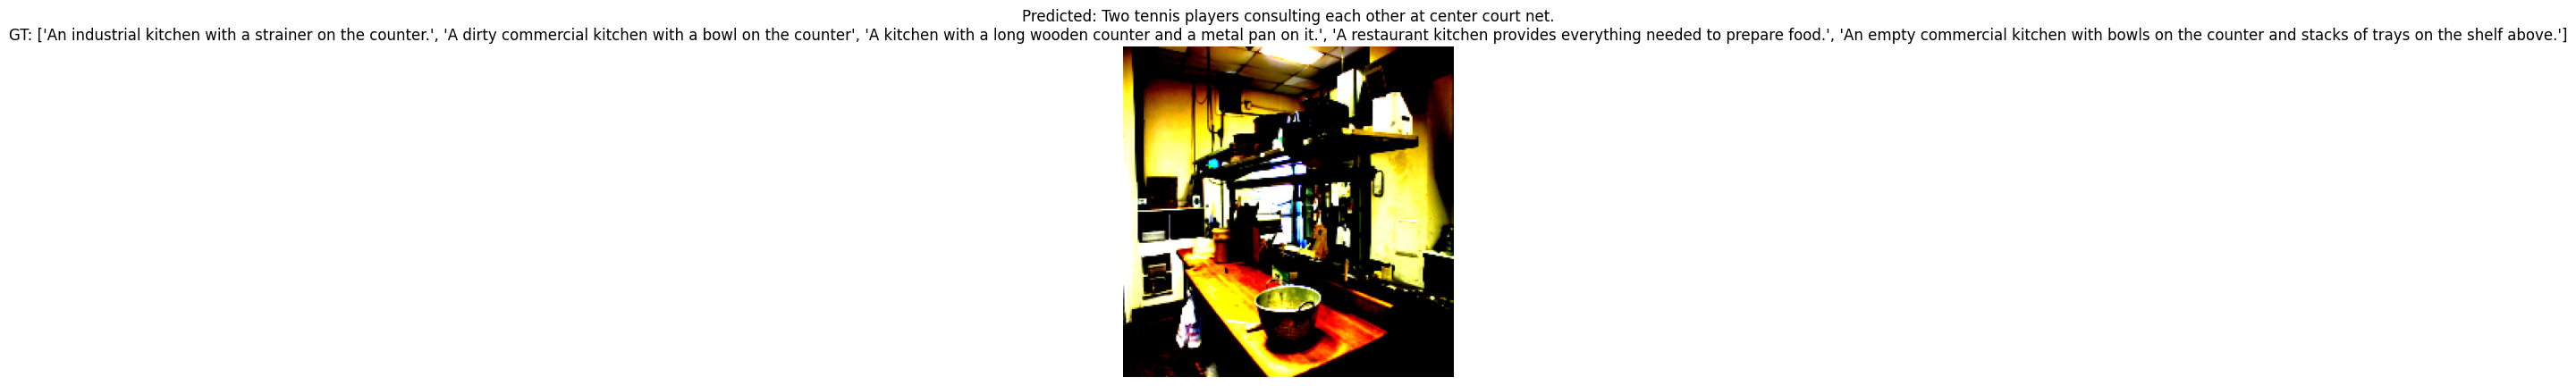

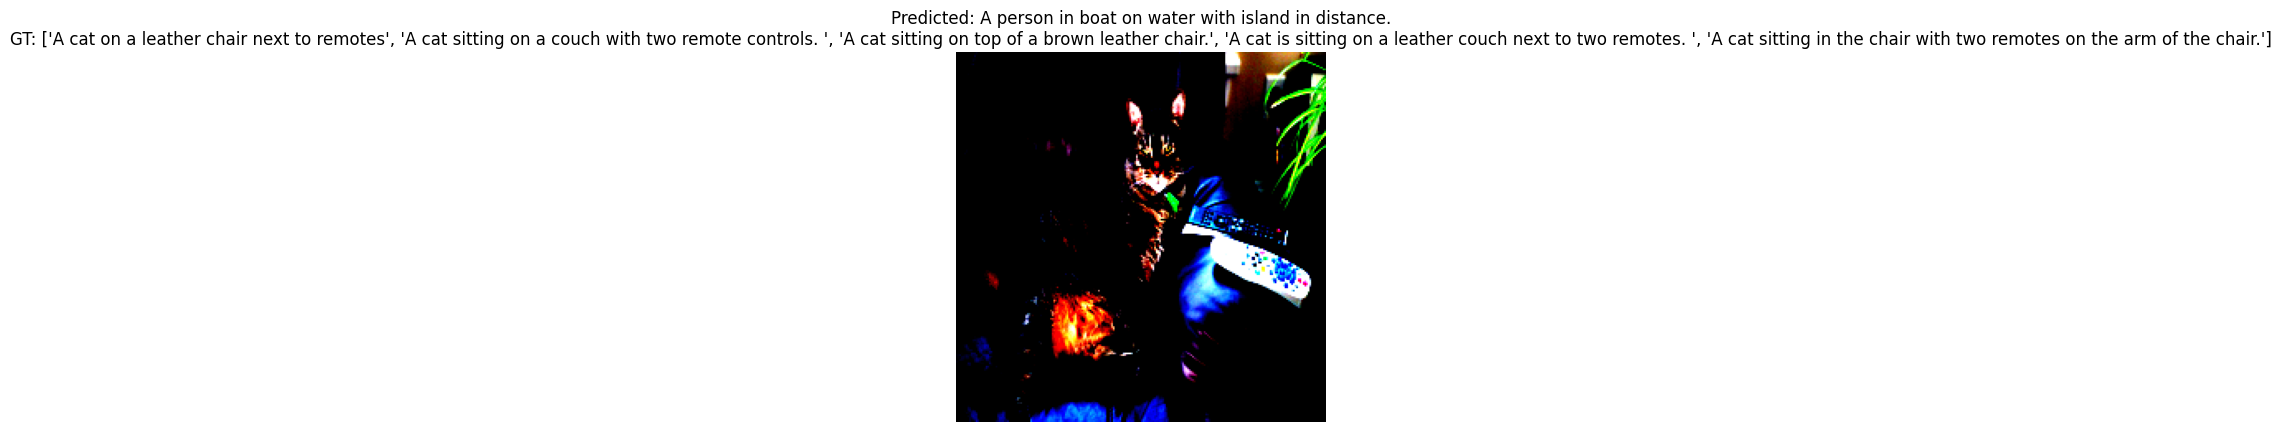

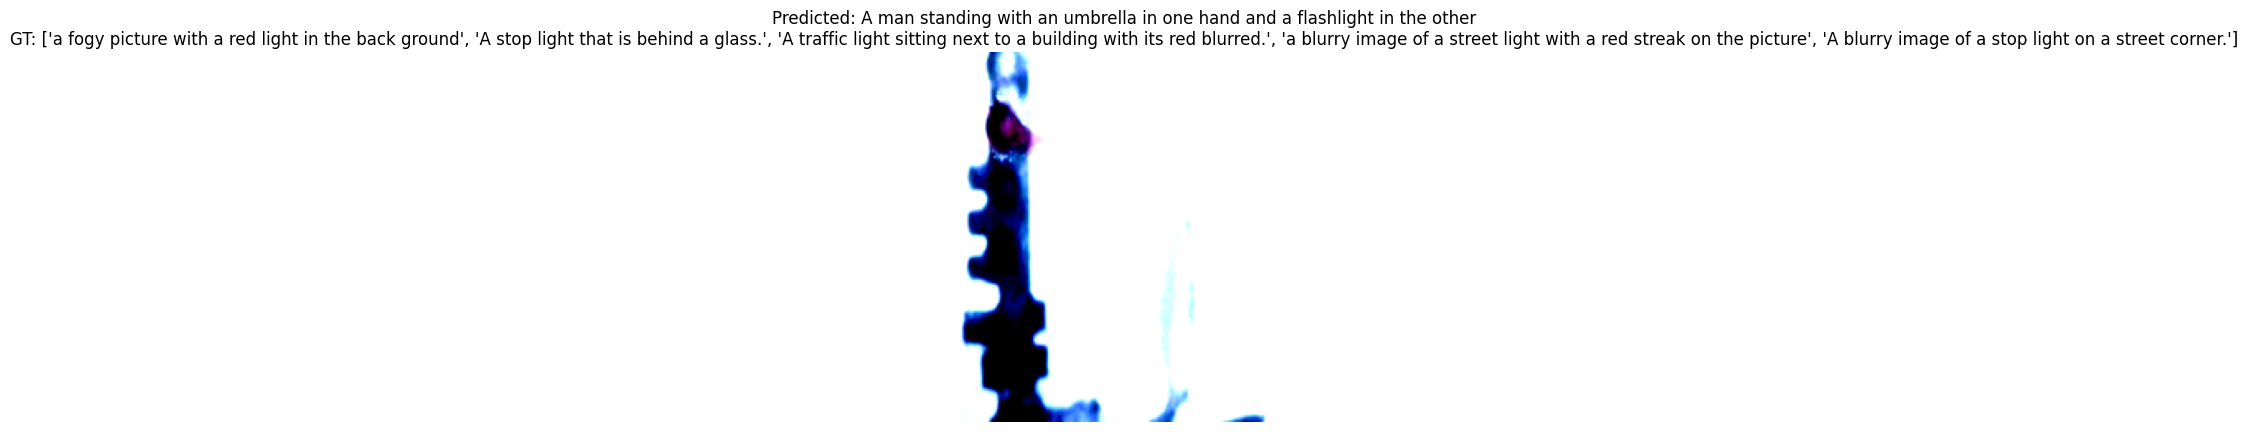

In [40]:
def visualize_images(image_indices, k=5):
    for idx in image_indices:
        image, gt_captions = coco_dset[idx]
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')

        predicted_caption = caption_image_knn(idx, k)
        plt.title(f"Predicted: {predicted_caption}\nGT: {gt_captions}")
        plt.show()

visualize_images([10, 20, 30, 40, 50], k=5)


In [45]:
import time
import matplotlib.pyplot as plt
import numpy as np
import faiss
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Ensure NLTK resources are downloaded (needed for tokenization)
nltk.download('punkt')

def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# Load COCO dataset
coco_dset = dset.CocoCaptions(root='/content/val2014',
                              annFile='/content/annotations/captions_val2014.json',
                              transform=get_transform())

# Load embeddings
caption_embeddings = np.load('/content/coco_captions.npy')
image_embeddings = np.load('/content/coco_imgs.npy')

# Flatten all captions into a single list
captions_flat = [caption for _, img_captions in coco_dset for caption in img_captions]

def find_k_nearest_images(image_embedding, k, index_type='flat', nlist=100):
    if index_type == 'flat':
        index = faiss.IndexFlatL2(image_embeddings.shape[1])
    elif index_type == 'ivf':
        quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])
        index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], nlist)
        if not index.is_trained:
            index.train(image_embeddings)
    else:
        raise ValueError(f"Unsupported index type: {index_type}")
    index.add(image_embeddings)
    _, I = index.search(image_embedding.reshape(1, -1), k)
    return I.flatten()

def compute_query_vector(nearest_image_indices):
    nearest_captions_indices = nearest_image_indices * 5  # Assuming 5 captions per image
    nearest_captions_indices = [idx for idx in nearest_captions_indices if idx < len(caption_embeddings)]
    return np.mean(caption_embeddings[nearest_captions_indices], axis=0)

def find_closest_caption(query_vector):
    index = faiss.IndexFlatL2(caption_embeddings.shape[1])
    index.add(caption_embeddings)
    _, I = index.search(query_vector.reshape(1, -1), 1)
    return captions_flat[I[0][0]]

def caption_image_knn(image_index, k, index_type='flat'):
    image_embedding = image_embeddings[image_index]
    nearest_indices = find_k_nearest_images(image_embedding, k, index_type=index_type)
    query_vector = compute_query_vector(nearest_indices)
    return find_closest_caption(query_vector)

def tokenize_and_preprocess(text):
    return nltk.word_tokenize(text.lower())

smoothing_func = SmoothingFunction().method1

# Benchmarking and BLEU score calculation
index_types = ['flat', 'ivf']
k = 5
results = {}

for index_type in index_types:
    start_time = time.time()
    predicted_captions = [caption_image_knn(i, k, index_type=index_type) for i in range(100)]
    elapsed_time = time.time() - start_time

    predicted_captions_tokenized = [tokenize_and_preprocess(pc) for pc in predicted_captions if pc]
    ground_truth_captions_tokenized = [[tokenize_and_preprocess(gt) for gt in gts if gt] for _, gts in coco_dset][:100]

    valid_pairs = [(gt, pc) for gt, pc in zip(ground_truth_captions_tokenized, predicted_captions_tokenized) if gt and pc]
    cumulative_bleu_scores = [sentence_bleu(gt, pc, smoothing_function=smoothing_func) for gt, pc in valid_pairs]
    average_cumulative_bleu_score = np.mean(cumulative_bleu_scores) if cumulative_bleu_scores else 0

    results[index_type] = {
        'time': elapsed_time,
        'bleu': average_cumulative_bleu_score
    }

# Displaying the results
for index_type, metrics in results.items():
    print(f"Index type: {index_type}, Time: {metrics['time']:.4f} seconds, Average BLEU: {metrics['bleu']}")

# Visualization function remains the same
def visualize_images(image_indices, k=5):
    for idx in image_indices:
        image, gt_captions = coco_dset[idx]
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')

        predicted_caption = caption_image_knn(idx, k)
        plt.title(f"Predicted: {predicted_caption}\nGT: {gt_captions}")
        plt.show()

visualize_images([10, 20, 30, 40, 50], k=5)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


ValueError: too many values to unpack (expected 2)